# This is Notebook 1 and it deals with EDA of the dataset and Data Modelling

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Packages

In [2]:
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re

## Load and Label Datasets

In [3]:
def load_subset(file_path, category_name):
    """Loads gzipped JSON dataset and adds a 'category' field."""
    def parse():
        with gzip.open(file_path, 'rb') as f:
            for line in f:
                item = json.loads(line)
                item['category'] = category_name
                yield item
    return pd.DataFrame(parse())

# Dataset info
datasets = [
    ("Toys_and_Games_5.json.gz", "Toys and Games"),
    ("Musical_Instruments_5.json.gz", "Musical Instruments"),
    ("Cell_Phones_and_Accessories_5.json.gz", "Cell Phones & Accessories"),
    ("Appliances_5.json.gz", "Appliances"),
    ("All_Beauty_5.json.gz", "All Beauty"),
    ("AMAZON_FASHION_5.json.gz", "Amazon Fashion")
]

base_path = "/content/drive/MyDrive/"
dfs = [load_subset(base_path + fname, cat) for fname, cat in datasets]

# Merge all subsets
df = pd.concat(dfs, ignore_index=True)
print(f"[INFO] Merged dataset: {df.shape[0]} rows")

[INFO] Merged dataset: 3199522 rows


## Clean and Normalize

In [4]:
# Rename relevant fields
df = df.rename(columns={
    "asin": "product_id",
    "reviewText": "review_text",
    "summary": "review_summary",
    "overall": "rating"
})

# Select relevant columns
df = df.loc[:, ["product_id", "review_text", "review_summary", "rating", "category"]]

# Drop null values
df = df.dropna(subset=["product_id", "review_text", "rating"])

# Clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))  # remove HTML
    text = re.sub(r'\s+', ' ', text)       # remove extra whitespace
    return text.strip()

df['review_text'] = df['review_text'].astype(str).apply(clean_text)
df['review_summary'] = df['review_summary'].astype(str).apply(clean_text)

# Drop reviews with < 5 words
df['word_count'] = df['review_text'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 5].drop(columns=['word_count'])

print(f"[INFO] Dataset after cleaning: {df.shape[0]} rows")

[INFO] Dataset after cleaning: 2630050 rows


## Exploratory Data Analysis

Unique products: 137635
Categories: 6 -> ['Toys and Games' 'Musical Instruments' 'Cell Phones & Accessories'
 'Appliances' 'All Beauty' 'Amazon Fashion']
Rating distribution:
 rating
5.0    1717089
4.0     434528
3.0     223356
1.0     140111
2.0     114966
Name: count, dtype: int64


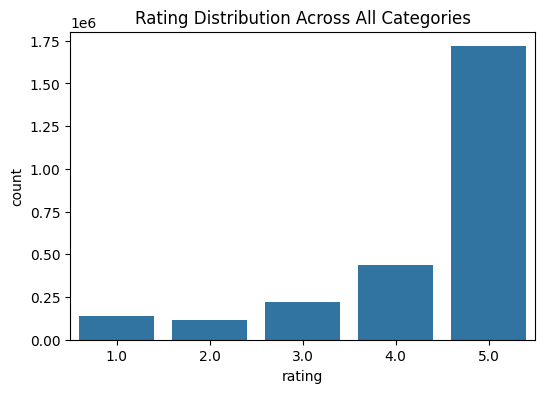

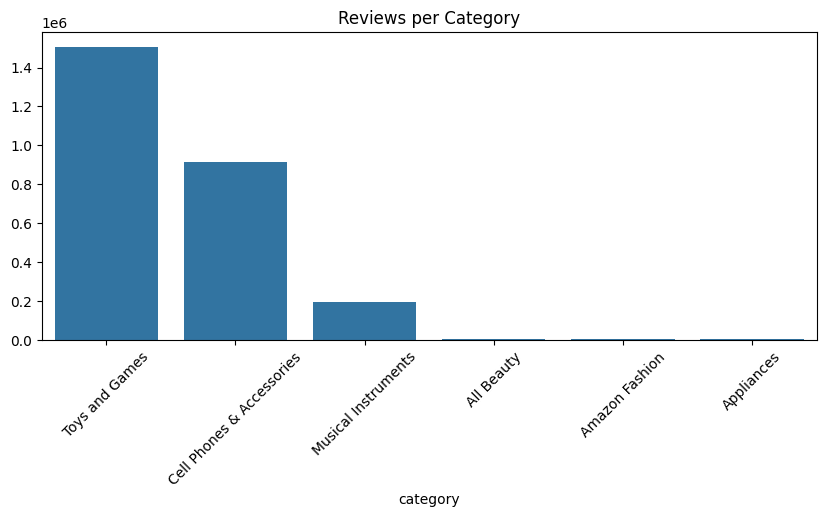

In [5]:
print(f"Unique products: {df['product_id'].nunique()}")
print(f"Categories: {df['category'].nunique()} -> {df['category'].unique()}")
print("Rating distribution:\n", df['rating'].value_counts())

# Plot rating distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="rating", data=df)
plt.title("Rating Distribution Across All Categories")
plt.show()

# Plot rows per category
category_counts = df["category"].value_counts()
plt.figure(figsize=(10, 4))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Reviews per Category")
plt.xticks(rotation=45)
plt.show()

##Saving Review-Level cleaned dataset

In [6]:
review_csv = base_path + "amazon_merged_reviews_cleaned.csv"
df.to_csv(review_csv, index=False)
print(f"[SAVED] Cleaned review-level dataset to: {review_csv}")

[SAVED] Cleaned review-level dataset to: /content/drive/MyDrive/amazon_merged_reviews_cleaned.csv


## Product Level dataset to build embeddings

In [7]:
#Aggregate to Product Level to deal with space complexity while building embeddings.
def aggregate_reviews(group):
    summary = group['review_summary'].fillna("").iloc[0]
    combined_reviews = " ".join(group['review_text'].fillna("").astype(str))
    category = group['category'].iloc[0]
    return pd.Series({
        "combined_text": (summary + " " + combined_reviews).strip()[:5000],  # truncate to 5K chars
        "category": category
    })

product_df = df.groupby('product_id').apply(aggregate_reviews).reset_index()
print(f"[INFO] Aggregated product-level dataset: {product_df.shape[0]} unique products")

#Save Product-Level Dataset

product_csv = base_path + "amazon_product_level.csv"
product_parquet = base_path + "amazon_product_level.parquet"

product_df.to_csv(product_csv, index=False, quoting=csv.QUOTE_ALL)
product_df.to_parquet(product_parquet, index=False)

print(f"[SAVED] Product CSV: {product_csv}")
print(f"[SAVED] Product Parquet: {product_parquet}")

/tmp/ipython-input-1377720046.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_df = df.groupby('product_id').apply(aggregate_reviews).reset_index()


[INFO] Aggregated product-level dataset: 137635 unique products
[SAVED] Product CSV: /content/drive/MyDrive/amazon_product_level.csv
[SAVED] Product Parquet: /content/drive/MyDrive/amazon_product_level.parquet


## Verify the Final Dataset obtained

In [8]:
# Sanity Check because the file obtained gets parser error often.
csv.field_size_limit(10**7)
df_test_csv = pd.read_csv(product_csv, engine='python')
print(f"Verified CSV Load: {df_test_csv.shape}")
df_test_parquet = pd.read_parquet(product_parquet)
print(f"Verified Parquet Load: {df_test_parquet.shape}")

Verified CSV Load: (137635, 3)
Verified Parquet Load: (137635, 3)
